In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

## Load The Data

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Strip whitespace from column names
cols = [c.strip() for c in df.columns]
if cols != list(df.columns):
    df.columns = cols

In [4]:
rename_map = {
'Annual Income (k$)': 'Annual_Income_k',
'Spending Score (1-100)': 'Spending_Score'
}
for k, v in rename_map.items():
    if k in df.columns:
        df = df.rename(columns={k: v})

print("Columns:", df.columns.tolist())

Columns: ['CustomerID', 'Gender', 'Age', 'Annual_Income_k', 'Spending_Score']


In [ ]:
# Checking for missing data
print("Missing values per column: \n", df.isna().sum())

Missing values per column: 
 CustomerID         0
Gender             0
Age                0
Annual_Income_k    0
Spending_Score     0
dtype: int64


In [16]:
df.describe()

,CustomerID,Age,Annual_Income_k,Spending_Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [19]:
df.duplicated().sum()

0

## EDA & Data Visualisation

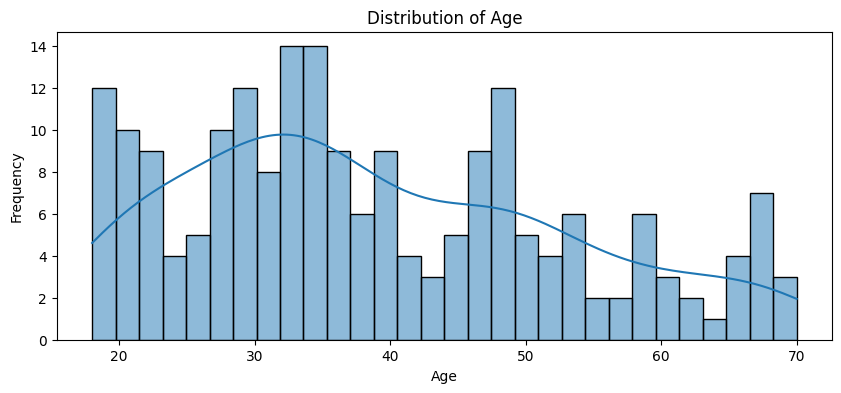

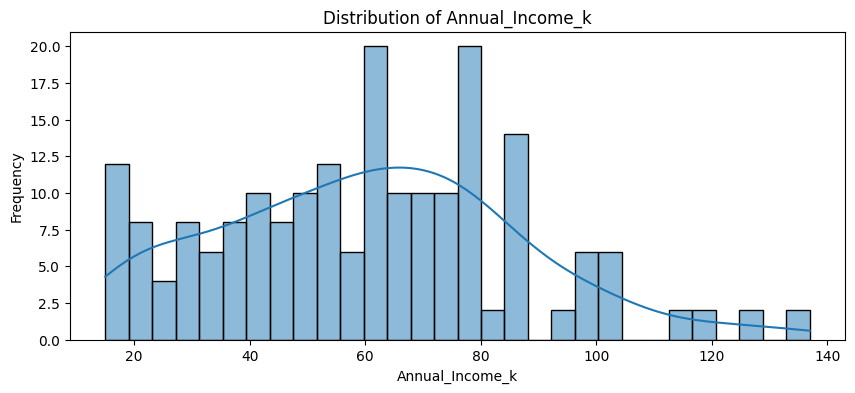

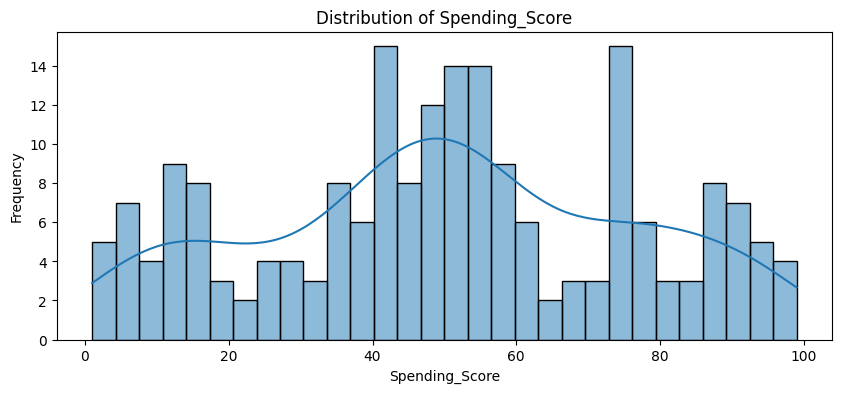

In [41]:
num_cols = ['Age', 'Annual_Income_k', 'Spending_Score']
for col in num_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

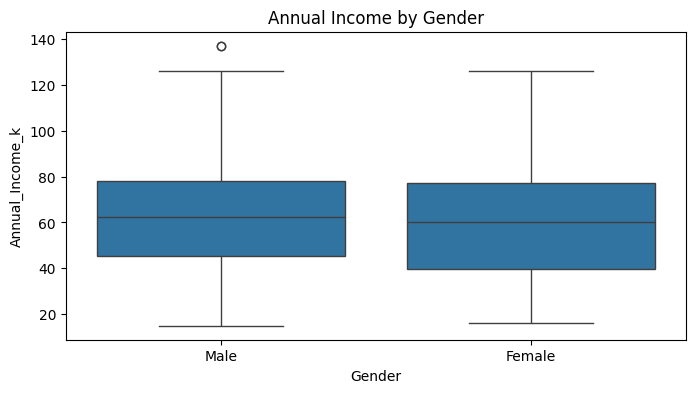

In [42]:
if 'Gender' in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Gender', y='Annual_Income_k', data=df)
    plt.title('Annual Income by Gender')
    plt.show()

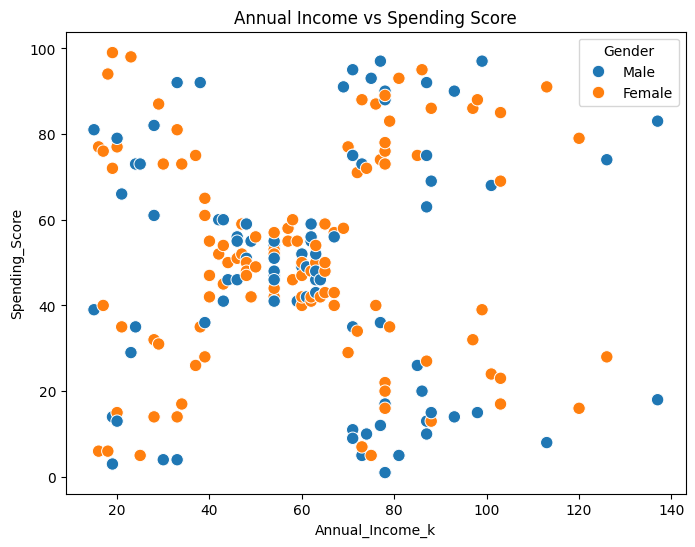

In [43]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual_Income_k', y='Spending_Score', hue='Gender' if 'Gender' in df.columns else None, data=df, s=80)
plt.title('Annual Income vs Spending Score')
plt.show()

In [44]:
# Feature Selection & Scaling
features = ['Annual_Income_k', 'Spending_Score']
X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [46]:
# Find optimal K (Elbow & Silhouette)
inertia = []
sil_scores = []
K_range = range(2,11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))


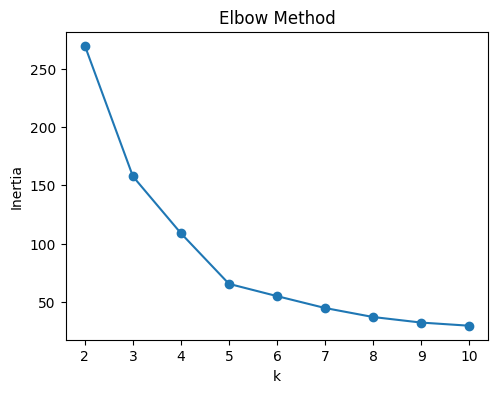

In [47]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

The Elbow Method plot shows a steep drop in inertia (WCSS) from k=2 to k=5, after which the curve starts to level off. Beyond k=5, the decrease in inertia becomes much smaller, and the line flattens. This suggests that 5 clusters is the optimal choice, as it balances compact clusters with model simplicity.


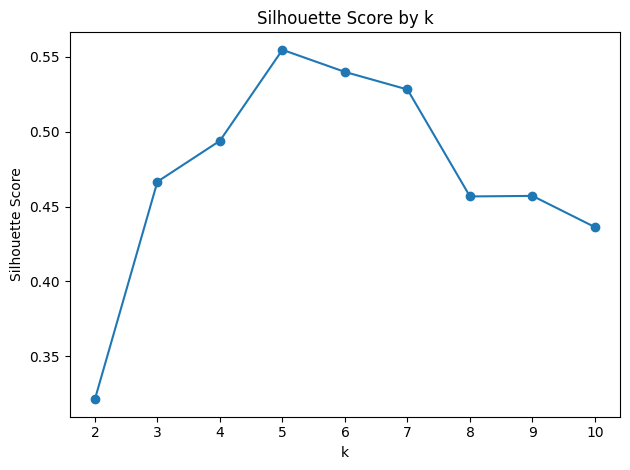

In [48]:
plt.plot(list(K_range), sil_scores, '-o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by k')
plt.tight_layout()

The Silhouette Score plot shows that the score increases sharply from k=2 to k=5, reaching its highest value at k=5 (~0.56). After k=5, the silhouette score gradually decreases, with a noticeable drop starting from k=7 onwards. This indicates that 5 clusters provide the best separation and cohesion, making it the most optimal choice compared to other values of k.

In [49]:
best_k = K_range[int(np.argmax(sil_scores)) - 2] if len(K_range) > 0 else 3

In [50]:
best_k = K_range[np.argmax(sil_scores)]
print(f"Best k by silhouette: {best_k}")

Best k by silhouette: 5


In [51]:
# KMeans Clustering
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_km = kmeans.fit_predict(X_scaled)
df['Cluster_KMeans'] = labels_km

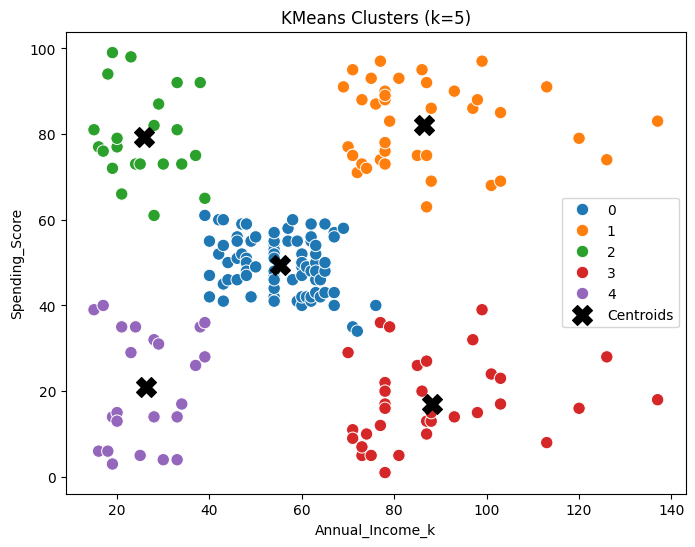

In [52]:
# Scatterplot: Clusters with centroids
plt.figure(figsize=(8,6))
palette = sns.color_palette('tab10', n_colors=best_k)
sns.scatterplot(x='Annual_Income_k', y='Spending_Score', hue='Cluster_KMeans', palette=palette, data=df, s=80)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], marker='X', s=200, c='black', label='Centroids')
plt.title(f'KMeans Clusters (k={best_k})')
plt.legend()

This scatter plot shows the KMeans clustering with 5 clusters, using Annual Income (x-axis) and Spending Score (y-axis).
Each color represents a distinct customer segment.
The black X markers represent the centroids of each cluster, indicating the average position of customers in that group.
We can clearly see well-separated clusters:
* One group with low income, low spending (purple).
* One with low income, high spending (green).
* One with medium income, medium spending (blue).
* One with high income, high spending (orange).
* One with high income, low spending (red).

This clustering highlights different customer behaviors and can help businesses target marketing strategies, such as focusing on the high-spending segments (orange & green) or trying to convert low-spending groups into higher-value customers.

Text(0.5, 1.0, 'Clusters visualized on PCA components')

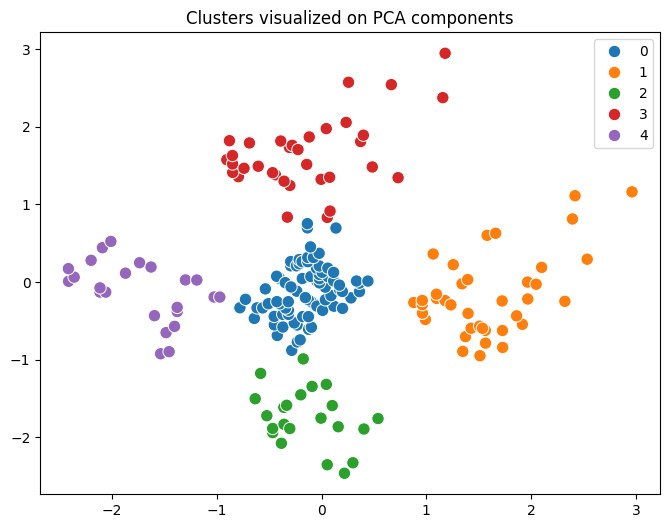

In [ ]:
# PCA visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_km, palette=palette, s=80)
plt.title('Clusters visualized on PCA components')


In [54]:
cluster_profile = df.groupby('Cluster_KMeans')[features + ['Age'] if 'Age' in df.columns else features].mean()
cluster_size = df['Cluster_KMeans'].value_counts().sort_index()
profile = cluster_profile.copy()
profile['size'] = cluster_size
print('\nCluster profile (averages and size):\n', profile)


Cluster profile (averages and size):
                 Annual_Income_k  Spending_Score        Age  size
Cluster_KMeans                                                  
0                     55.296296       49.518519  42.716049    81
1                     86.538462       82.128205  32.692308    39
2                     25.727273       79.363636  25.272727    22
3                     88.200000       17.114286  41.114286    35
4                     26.304348       20.913043  45.217391    23


In [ ]:
# Average spending per cluster
avg_spending = df.groupby('Cluster_KMeans')['Spending_Score'].mean().sort_values(ascending=False)
print('\nAverage Spending Score per cluster:\n', avg_spending)



Average Spending Score per cluster:
 Cluster_KMeans
1    82.128205
2    79.363636
0    49.518519
4    20.913043
3    17.114286
Name: Spending_Score, dtype: float64


/var/folders/yb/g6h5659x6z78yqc35_kfmpfm0000gn/T/ipykernel_5991/3287803246.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_spending.index, y=avg_spending.values, palette="viridis")


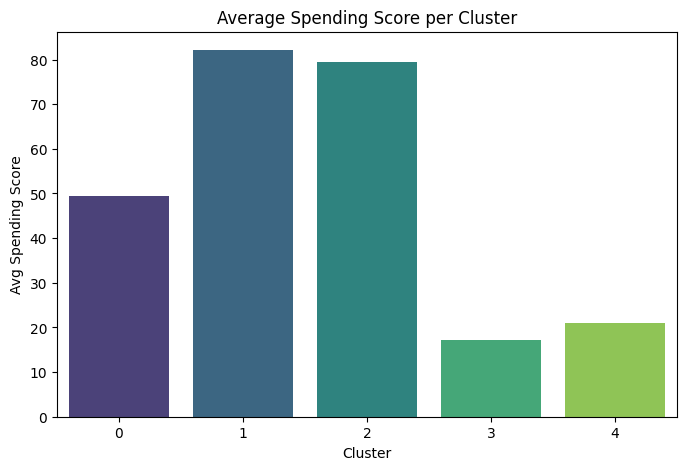

In [60]:
plt.figure(figsize=(8,5))
sns.barplot(x=avg_spending.index, y=avg_spending.values, palette="viridis")
plt.title("Average Spending Score per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Avg Spending Score")
plt.show()

In [ ]:
# ---------------- DBSCAN ----------------
# Use Nearest Neighbors to estimate eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:,4])

Text(0.5, 1.0, 'Knee plot for DBSCAN eps selection')

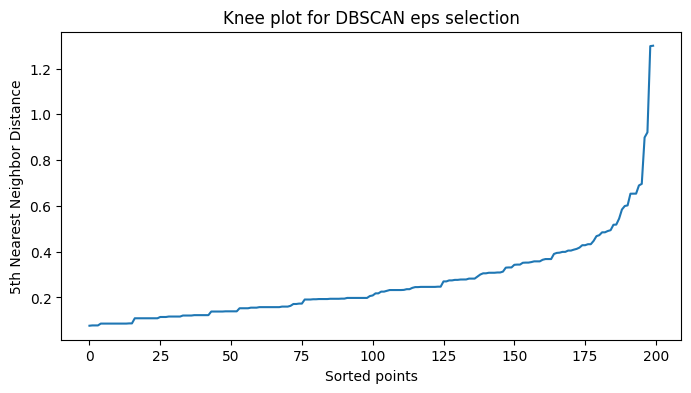

In [57]:
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.ylabel('5th Nearest Neighbor Distance')
plt.xlabel('Sorted points')
plt.title('Knee plot for DBSCAN eps selection')

In [61]:
# Run DBSCAN
db = DBSCAN(eps=0.6, min_samples=5)
labels_db = db.fit_predict(X_scaled)
df['Cluster_DBSCAN'] = labels_db
unique_db = np.unique(labels_db)
print('DBSCAN cluster labels:', unique_db)

DBSCAN cluster labels: [-1  0]


Text(0.5, 1.0, 'DBSCAN results')

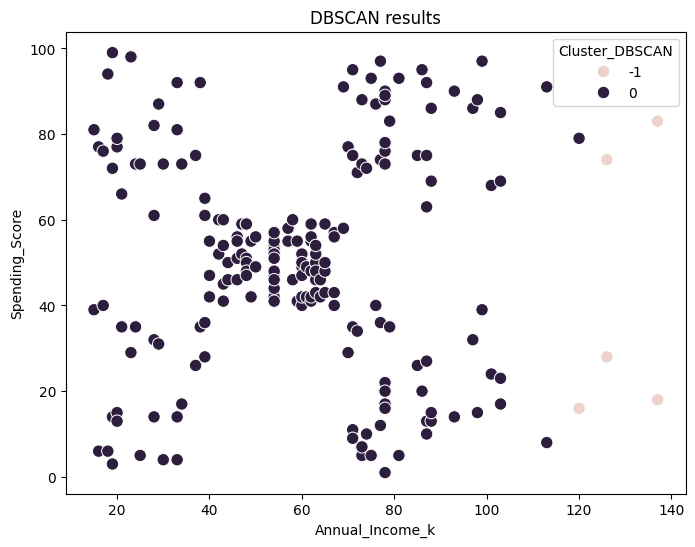

In [62]:


# DBSCAN visualization

plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual_Income_k', y='Spending_Score', hue='Cluster_DBSCAN', data=df, s=80)
plt.title('DBSCAN results')

This scatter plot shows the DBSCAN clustering using Annual Income (x-axis) and Spending Score (y-axis).
DBSCAN identified:
* Cluster 0 (dark purple): the main dense group of customers.
* Cluster -1 (light pink): outliers with higher incomes and varied spending.

Unlike KMeans, DBSCAN forms clusters based on density, so here it found one main cluster and treated scattered points as noise. This highlights a core customer group and a few unusual spending patterns.